In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd 
import wandb
import yaml
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

sns.set(context='paper', 
        style='ticks', 
        palette='deep', 
        font='Linux Libertine O', 
        font_scale=2.5, 
        rc={
            'mathtext.fontset': 'stix',
            'lines.linewidth' : 4,
            'lines.markersize' : 12,
        }
)
sns.despine()
os.makedirs('figs', exist_ok=True)

<Figure size 640x480 with 0 Axes>

In [3]:
def get_dp_level(method: str):
    if method.endswith('-$\infty$'): return 'none'
    if method.endswith('-EDP'): return 'edge'
    if method.endswith('-NDP'): return 'node'
    if method == 'MLP': return 'edge'
    if method == 'MLP-DP': return 'node'

def generate_noisy_values(df, metric_mean, metric_ci, num_samples=1000):
    df['noise'] = [np.random.randn(num_samples)] * len(df)
    df['noise'] = df['noise'] * df[metric_ci]
    df = df.explode(column='noise')
    df = df.reset_index(drop=True)
    df[metric_mean] += df['noise']
    return df

In [13]:
with open('wandb.yaml') as f:
    wandb_config = yaml.safe_load(f)

api = wandb.Api()
runs = api.runs(f"{wandb_config['username']}/{wandb_config['project']['train']}", per_page=2000)

i = 0
data_list = []

for run in tqdm(runs): 
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data['id'] = i
    data['method'] = data['method'].upper().replace('INF', '$\infty$').replace('PRO', 'Pro')    
    data_list.append(data)
    i += 1

runs = api.runs(f"sisaman/GAP-TRAIN", per_page=2000)
for run in tqdm(runs):
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data['id'] = i
    data['method'] = data['method'].upper().replace('INF', '$\infty$')    
    data_list.append(data)
    i += 1

100%|██████████| 1175/1175 [00:00<00:00, 38928.18it/s]


# Trade-offs between Privacy and Accuracy

### Main results

In [15]:
cols = ['id', 'method', 'dataset', 'epsilon', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['ProGAP-$\infty$', 'GAP-$\infty$', 'ProGAP-EDP', 'GAP-EDP', 'MLP', 'ProGAP-NDP', 'GAP-NDP', 'MLP-DP']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df['dp_level'] = df['method'].apply(get_dp_level)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['dp_level'] == 'none', 'epsilon'] = np.inf
df = df.loc[(df['dp_level'] != 'edge') | (df['epsilon'].isin([0,4]))]
df = df.loc[(df['dp_level'] != 'node') | (df['epsilon'] == 8)]

# df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = df.loc[df['method'] == 'SAGE-NDP', 'train/acc_mean'] # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.drop(columns=['id', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci'])

def sort_key(row):
    keys = {
        'facebook': 1, 'reddit': 2, 'amazon': 3,     # datasets
        'ProGAP-$\infty$': 1, 'GAP-$\infty$': 2, 'ProGAP-EDP': 3, 'GAP-EDP': 4, 'MLP': 5, 'ProGAP-NDP': 6, 'GAP-NDP': 7, 'MLP-DP': 8,  # methods
        'none': 1, 'edge': 2, 'node': 3,  # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'dp_level', 'method'], key=sort_key)
df = df.pivot(columns='dataset', index=['dp_level', 'method', 'epsilon'], values='acc')
df = df.reset_index().sort_values(
    by=['dp_level', 'method'],
    key=sort_key
).set_index(['dp_level', 'method', 'epsilon'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'dp_level': 'Privacy Level', 'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
df = df.rename({np.inf: '$\infty$'}, axis=0, level=2)
# print(df.to_latex(escape=False))
df

Dataset                                            Facebook           Reddit  \
Privacy Level Method          Privacy Cost                                     
None          ProGAP-$\infty$ $\infty$      84.6 $\pm$ 0.17  99.1 $\pm$ 0.03   
              GAP-$\infty$    $\infty$      80.6 $\pm$ 0.30  99.4 $\pm$ 0.01   
Edge          ProGAP-EDP      4.0           82.3 $\pm$ 0.25  98.8 $\pm$ 0.04   
              GAP-EDP         4.0           76.6 $\pm$ 0.31  98.7 $\pm$ 0.03   
              MLP             0.0           50.6 $\pm$ 0.21  82.4 $\pm$ 0.09   
Node          ProGAP-NDP      8.0           68.7 $\pm$ 0.45  94.0 $\pm$ 0.12   
              GAP-NDP         8.0           63.3 $\pm$ 0.38  93.9 $\pm$ 0.07   
              MLP-DP          8.0           50.0 $\pm$ 0.33  81.4 $\pm$ 0.10   

Dataset                                              Amazon  
Privacy Level Method          Privacy Cost                   
None          ProGAP-$\infty$ $\infty$      92.2 $\pm$ 0.07  
              GAP-$\infty$    $\infty$      91.5 $\pm$ 0.07  
Edge          ProGAP-EDP      4.0           88.3 $\pm$ 0.23  
              GAP-EDP         4.0           84.2 $\pm$ 0.14  
              MLP             0.0           71.1 $\pm$ 0.16  
Node          ProGAP-NDP      8.0           78.8 $\pm$ 0.13  
              GAP-NDP         8.0           77.6 $\pm$ 0.07  
              MLP-DP          8.0           73.6 $\pm$ 0.07

## Edge-level DP

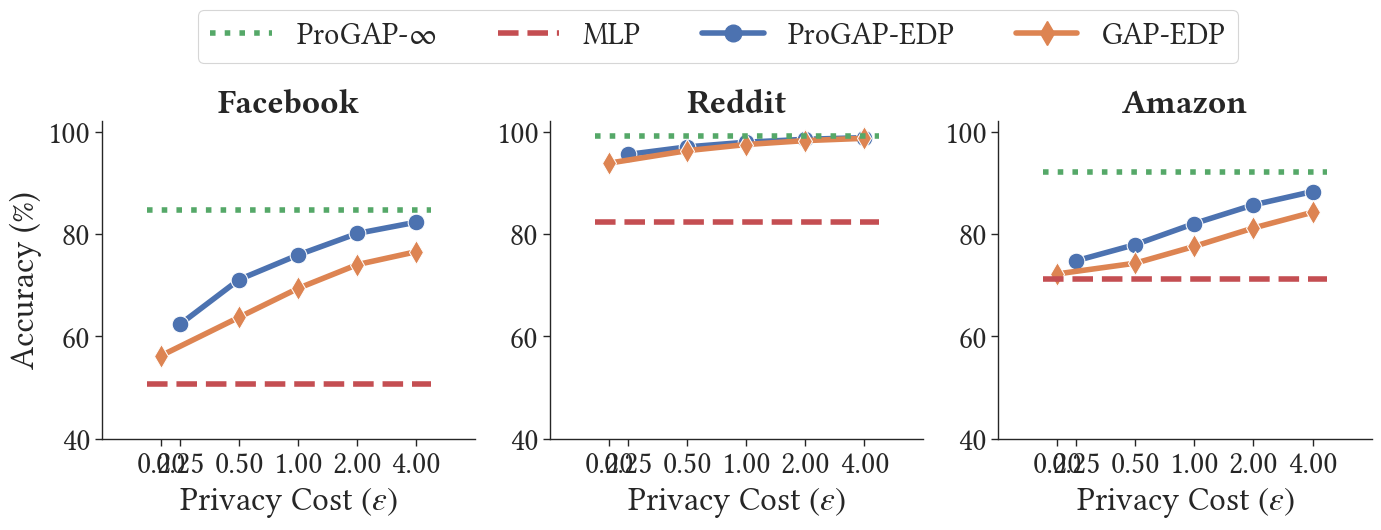

In [18]:
cols = ['id', 'method', 'dataset', 'epsilon', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-$\infty$', 'MLP', 'ProGAP-EDP', 'GAP-EDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [0.2, 0.25, 0.5, 1, 2, 4]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['method'] == 'ProGAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

inf_acc = df.loc[df['method'] == 'ProGAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
mlp_acc = df.loc[df['method'] == 'MLP', ['dataset', 'test/acc_mean']].set_index('dataset')
edp_methods = ['ProGAP-EDP', 'GAP-EDP']
df = df.loc[df['method'].isin(edp_methods)]
df = df.sort_values(by='method')

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=['o', 'd'], dashes=False, style='method',
                hue_order=edp_methods, col_order=datasets, style_order=edp_methods,
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2), ylim=(40, 102))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='ProGAP-$\infty$', color=sns.color_palette('deep')[2], xmin=0.12, xmax=0.88)
    ax.axhline(mlp_acc.loc[dataset].item(), linestyle='dashed', label='MLP', color=sns.color_palette('deep')[3], xmin=0.12, xmax=0.88)
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
g.axes[0][1].legend(loc='upper center', ncol=4, bbox_to_anchor=(.45, 1.4), handles=[legend_data[method] for method in methods], labels=methods)

g.axes[0][0].set(ylabel='Accuracy (%)')
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/edge.pdf')

## Node-level DP

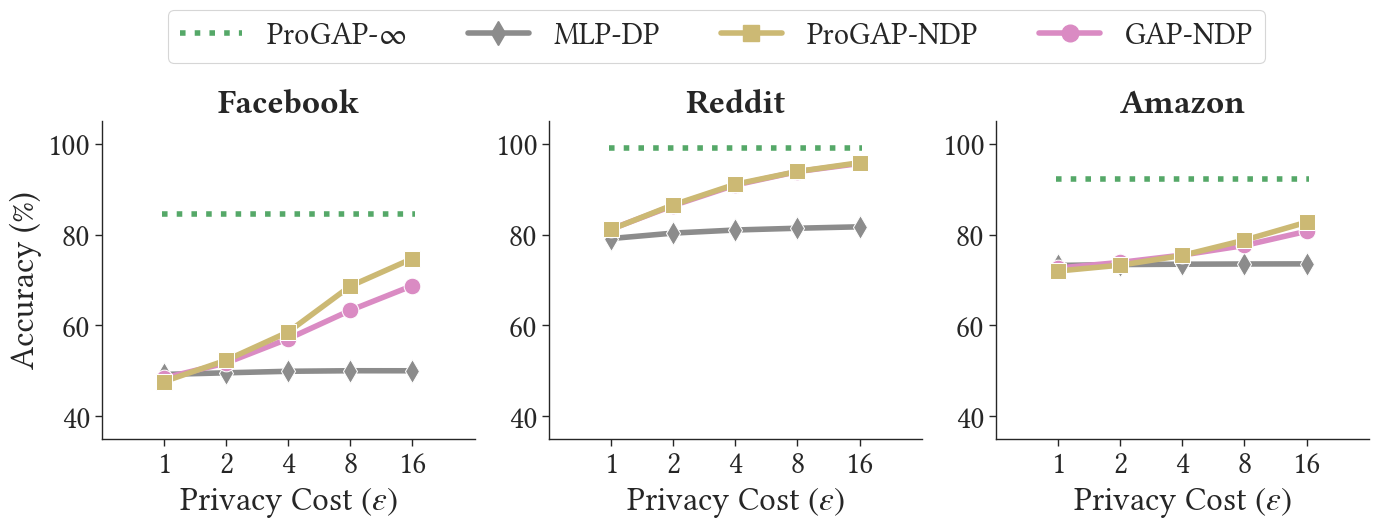

In [33]:
cols = ['id', 'method', 'dataset', 'epsilon', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-$\infty$', 'MLP-DP', 'ProGAP-NDP', 'GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [1, 2, 4, 8, 16]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'ProGAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[np.inf])]

# select best models based on valication accuracy
# df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = df.loc[df['method'] == 'SAGE-NDP', 'train/acc_mean'] # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

inf_acc = df.loc[df['method'] == 'ProGAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
ndp_methods = ['MLP-DP', 'GAP-NDP', 'ProGAP-NDP']
df = df.loc[df['method'].isin(ndp_methods)]
df['epsilon'] = df['epsilon'].astype(int)

# plot
palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=['d', 'o', 's'], dashes=False, style='method',
                hue_order=ndp_methods, col_order=datasets, style_order=ndp_methods, 
                palette=[palette[-3], palette[-4], palette[-2]],
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2), ylim=(35, 105))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='ProGAP-$\infty$', color=sns.color_palette('deep')[2], xmin=0.16, xmax=0.84)
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
g.axes[0][1].legend(loc='upper center', ncol=4, bbox_to_anchor=(.45, 1.4), handles=[legend_data[method] for method in methods], labels=methods)

g.axes[0][0].set(ylabel='Accuracy (%)')

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/node.pdf')

# Effect of the number of stages

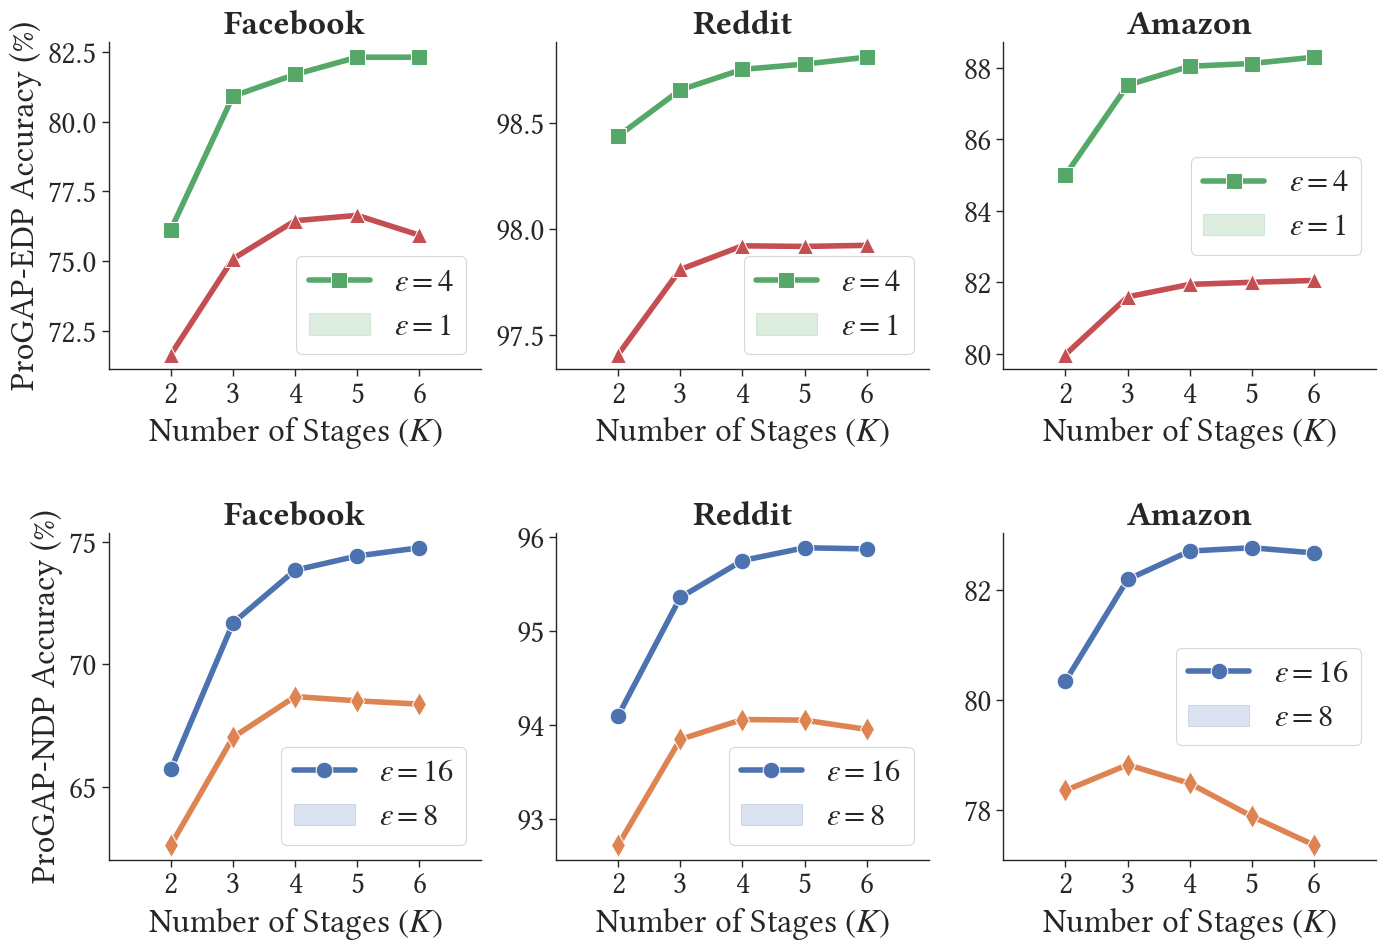

In [28]:
cols = ['method', 'dataset', 'epsilon', 'stages', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-EDP', 'ProGAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons_edp = [1,4]
epsilons_ndp = [8,16]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]

mask_edp = (df['method'] == 'ProGAP-EDP') & df['epsilon'].isin(epsilons_edp)
mask_ndp = (df['method'] == 'ProGAP-NDP') & df['epsilon'].isin(epsilons_ndp)
df = df.loc[mask_edp | mask_ndp]

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'stages'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(int).astype(str)
df['style'] = df['method'].str.cat(df['epsilon'], sep='-')

g = sns.relplot(kind='line', data=df, hue='style', y='test/acc_mean', x='stages', col='dataset', row='method', aspect=1.2,
                col_order=datasets, row_order=methods, markers=['o', 'd', 's', '^'], dashes=False, style='style', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

legend_loc = {
    ('ProGAP-EDP', 'amazon'): 'lower right',
    # ('GAP-NDP', 'facebook'): 'right',
}

g.set(xlabel='Number of Stages $(K)$', xlim=(1,7), xticks=range(2,7))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps}$' for eps in df.loc[(df['method'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
            # loc=legend_loc.get((method, dataset), None),
        )
        ax.set_ylabel(f'{method} Accuracy (%)' if dataset == datasets[0] else None)
        
# g.axes[0][0].set(ylim=(65,80))
# g.axes[0][1].set(ylim=(97,99.1)); # g.axes[0][1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# g.axes[0][2].set_ylim(70,85)
# g.axes[1][0].set_ylim(55,70)
# g.axes[1][1].set(ylim=(92,96))
# g.axes[1][2].set_ylim(76,82)


g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/stages.pdf')
# df

# Effect of the maximum degree

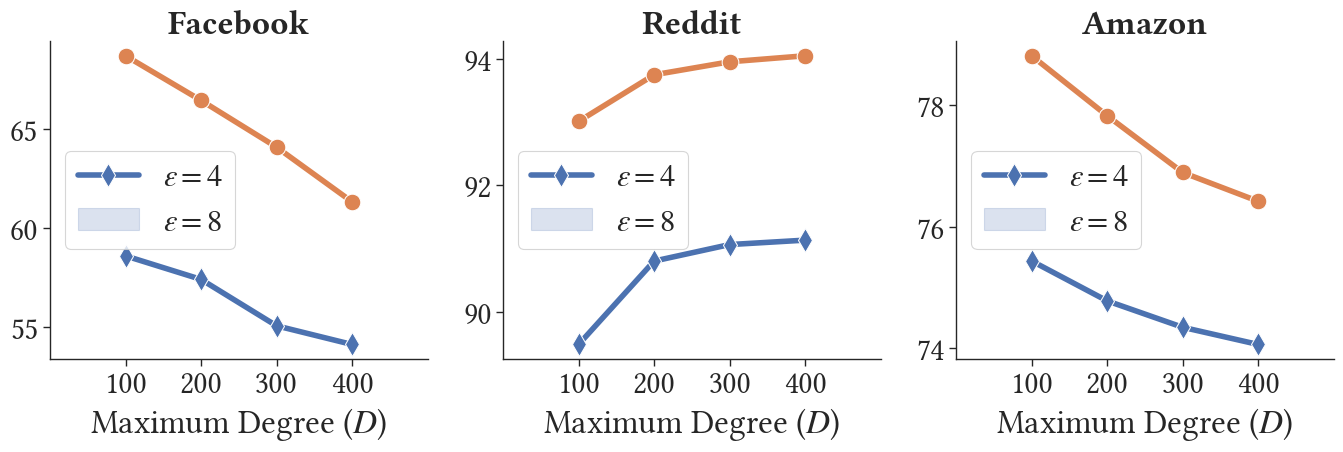

In [31]:
cols = ['method', 'dataset', 'epsilon', 'max_degree', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-NDP']
datasets = ['facebook', 'reddit', 'amazon']
epsilons = [4,8]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'max_degree'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(int).astype(str)

g = sns.relplot(kind='line', data=df, x='max_degree', y='test/acc_mean', hue='epsilon',
                col='dataset', aspect=1.2,
                col_order=datasets, 
                hue_order=epsilons, 
                markers=['o', 'd'], dashes=False, style='epsilon', legend=False,
                facet_kws={'sharey': False, 'sharex': False})

g.set(xlabel='Maximum Degree ($D$)', ylabel=None, xlim=(0,500))
for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.set_xticks(range(100,500,100))
    ax.legend(labels=[f"$\epsilon={eps}$" for eps in epsilons], ncol=1,)
        
# g.axes[0][0].set(ylim=(45,70), ylabel='ProGAP-NDP Accuracy (%)')
# g.axes[0][1].set_ylim(80,100)
# g.axes[0][2].set_ylim(73,81)

g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
g.fig.set_figwidth(14)
g.savefig('figs/degree.pdf')